# Movie recommendation using ALS in Spark

The goal of this project is to use Alternating Least Squares (ALS) in Spark to recommend movies.

Look at:
* Need to minimise overfitting!
* https://github.com/recommenders-team/recommenders/blob/main/examples/02_model_collaborative_filtering/als_deep_dive.ipynb

# Background (placeholder)

**Recommendation systems**












* Collaborative filtering
* ALS matrix factorization

**References**
*


# Train a model (locally)
Before training a model in the cloud, a smaller model will be trained locally using PySpark. This will enable validation of the approach.

## Set-up

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import dependencies
from math import sqrt
from matplotlib import pyplot as plt
import pandas as pd

In [3]:
# Create a spark context and session
%cd
!apt-get update -qq
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!tar -xzf '/content/drive/MyDrive/Data science jobs/3. Interview prep/Google Cloud/Dataproc/spark-3.0.1-bin-hadoop2.7.tgz'
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/root/spark-3.0.1-bin-hadoop2.7"
%cd /content

import findspark
findspark.init()
import pyspark
sc = pyspark.SparkContext.getOrCreate()
spark = pyspark.sql.SparkSession.builder.getOrCreate()
print(sc)
print(spark)

/root
/content
<SparkContext master=local[*] appName=pyspark-shell>


## Training/test data prep

**Key observations:**

* The dataset consists of 1501 records.

* It contains the following four columns: 'userID', 'movieID', 'rating' and 'timestamp'. These are seperated by '::'

* Two Spark DataFrames are created. These correspond to training/test data

  Note: Data is read into an RDD initially.

In [4]:
!wc "/content/drive/MyDrive/Data science jobs/3. Interview prep/Google Cloud/Dataproc/sample_movielens_ratings.txt"
print("\n")
!head -n 5 "/content/drive/MyDrive/Data science jobs/3. Interview prep/Google Cloud/Dataproc/sample_movielens_ratings.txt"

 1501  1501 32363 /content/drive/MyDrive/Data science jobs/3. Interview prep/Google Cloud/Dataproc/sample_movielens_ratings.txt


0::2::3::1424380312
0::3::1::1424380312
0::5::2::1424380312
0::9::4::1424380312
0::11::1::1424380312


In [5]:
# Read into RDD
records = spark.read.text("/content/drive/MyDrive/Data science jobs/3. Interview prep/Google Cloud/Dataproc/sample_movielens_ratings.txt").rdd
display(records.take(1))
elements = records.map(lambda row: row.value.split('::')) # Split columns
display(elements.take(1))

# Create DataFrame using pyspark.sql.Row object
from pyspark.sql import Row
row_RDD = elements.map(lambda row: Row(userId=int(row[0]), movieId=int(row[1]), rating=float(row[2]), timestamp=int(row[3])))
display(row_RDD.take(1))

ratings_DF = spark.createDataFrame(row_RDD)
print(f"\nRows: {ratings_DF.count()}")
ratings_DF.show(5)
ratings_DF.printSchema()

[Row(value='0::2::3::1424380312')]

[['0', '2', '3', '1424380312']]

[Row(userId=0, movieId=2, rating=3.0, timestamp=1424380312)]


Rows: 1501
+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     0|      2|   3.0|1424380312|
|     0|      3|   1.0|1424380312|
|     0|      5|   2.0|1424380312|
|     0|      9|   4.0|1424380312|
|     0|     11|   1.0|1424380312|
+------+-------+------+----------+
only showing top 5 rows

root
 |-- userId: long (nullable = true)
 |-- movieId: long (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: long (nullable = true)



In [6]:
# Train/test split
(training_DF, valid_DF) = ratings_DF.randomSplit([0.8, 0.2], seed=0)
print(f"Training set rows: {training_DF.count()}")
training_DF.show(5)
training_DF.printSchema()
print(f"\nValidation set rows: {valid_DF.count()}")
valid_DF.show(5)
valid_DF.printSchema()

# Register tables enabling SQL queries
training_DF.createOrReplaceTempView('training_DF')
valid_DF.createOrReplaceTempView('valid_DF')

Training set rows: 1183
+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     0|      2|   3.0|1424380312|
|     0|      3|   1.0|1424380312|
|     0|      5|   2.0|1424380312|
|     0|      9|   4.0|1424380312|
|     0|     11|   1.0|1424380312|
+------+-------+------+----------+
only showing top 5 rows

root
 |-- userId: long (nullable = true)
 |-- movieId: long (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: long (nullable = true)


Validation set rows: 318
+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     0|     44|   1.0|1424380312|
|     0|     45|   2.0|1424380312|
|     0|     55|   1.0|1424380312|
|     0|     59|   2.0|1424380312|
|     0|     61|   2.0|1424380312|
+------+-------+------+----------+
only showing top 5 rows

root
 |-- userId: long (nullable = true)
 |-- movieId: long (nullable = true)
 |-- rating: double (nullable = true

## Baseline

**Key observation:**
* A naive prediction will be used to construct a baseline model. This will be the mean rating across all movies.

* The performance of this baseline model is estimated using root-mean-squared error.

In [7]:
# Naive prediction
row_baseline = spark.sql("SELECT AVG(rating) FROM training_DF").collect()[0] # query returns dataframe with only 1 row
naive_pred = row_baseline["avg(rating)"]
print(naive_pred)

1.7675401521555367


In [8]:
# Squared error for each movie
se_RDD = valid_DF.rdd.map(lambda row: Row(se=pow(row['rating']-naive_pred, 2)))
se_DF = spark.createDataFrame(se_RDD)
se_DF.createOrReplaceTempView("se_DF")
se_DF.show(5)

# RMSE
row_avg = spark.sql("SELECT AVG(se) FROM se_DF").collect()[0] # query returns dataframe with only 1 row
baseline_rmse = sqrt(row_avg["avg(se)"])
print(f"Baseline RMSE: {baseline_rmse}")

+--------------------+
|                  se|
+--------------------+
|  0.5891178851709444|
|0.054037580859871016|
|  0.5891178851709444|
|0.054037580859871016|
|0.054037580859871016|
+--------------------+
only showing top 5 rows

Baseline RMSE: 1.1701597619641344


## Hyperparameter tuning

**Key observations:**

* An [ALS estimator](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.recommendation.ALS.html#pyspark.ml.recommendation.ALS) is created and cross-validation is used to assess different values for 'rank', 'regParam' and 'maxIter'.

  Where, 'rank' is the number of latent factors in the model and 'regParam' is the coefficient of the regularisation term.

* By default, the CrossValidator returns the model with the highest average cross-validation metric across folds.

* Root-mean-squared-error was used to evaluate performance.

In [9]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

# ALS estimator
als = ALS(maxIter=10,
          rank=15,
          regParam=0.1,
          userCol="userId",
          itemCol="movieId",
          ratingCol="rating",
          nonnegative=True,
          coldStartStrategy='drop',
          seed=1)

# Parameter grid
# Source: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.ParamGridBuilder.html#pyspark.ml.tuning.ParamGridBuilder
param_grid = ParamGridBuilder().addGrid(als.rank, [10]).addGrid(als.regParam, [0.05]).addGrid(als.maxIter, [5]).build()

# Regression evaluator
# Source: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.RegressionEvaluator.html#pyspark.ml.evaluation.RegressionEvaluator
reg_eval = RegressionEvaluator(metricName="rmse",
                               labelCol="rating",
                               predictionCol="prediction")

# k-fold cross validation
# Source: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.CrossValidator.html
kfold_cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=reg_eval, numFolds=5)
cv_model = kfold_cv.fit(training_DF)

## Best model
**Key observations:**
* The best model is saved locally.

* [After identifying the best ParamMap, CrossValidator finally re-fits the Estimator using the best ParamMap and the entire dataset.](https://spark.apache.org/docs/latest/ml-tuning.html)

In [10]:
# Optimal hyperparameters
# Note: Parameter maps and metrics are local Python lists hence pandas dataframe
cv_output = list(zip(cv_model.getEstimatorParamMaps(), cv_model.avgMetrics))
cv_output = pd.DataFrame(cv_output, columns=["parameters", "rmse"])
cv_output.sort_values(by=["rmse"]).head()

print(f'Lowest RMSE: {cv_output.iloc[cv_output["rmse"].idxmin(), 1]}')
print("Congiguration: ")
display(cv_output.iloc[cv_output["rmse"].idxmin(), 0])

Lowest RMSE: 1.2237483096130854
Congiguration: 


{Param(parent='ALS_65d5889a64bc', name='rank', doc='rank of the factorization'): 10,
 Param(parent='ALS_65d5889a64bc', name='regParam', doc='regularization parameter (>= 0).'): 0.05,
 Param(parent='ALS_65d5889a64bc', name='maxIter', doc='max number of iterations (>= 0).'): 5}

In [11]:
# Save best model
MODEL_PATH = "/content/drive/MyDrive/Data science jobs/3. Interview prep/Google Cloud/Dataproc/local_movie_rec"
local_model = cv_model.bestModel
local_model.write().overwrite().save(MODEL_PATH)

# from pyspark.ml.recommendation import ALSModel
# del local_model
# local_model = ALSModel.load(MODEL_PATH)

In [12]:
# Factorised user and item matrix
print(f"Factorised user matrix (rank: {local_model.rank})")
local_model.userFactors.show(5, truncate=False)
print("_"*50, "\n"*2)
print(f"Factorised item matrix (rank: {local_model.rank})")
local_model.itemFactors.show(5, truncate=False)

Factorised user matrix (rank: 10)
+---+-----------------------------------------------------------------------------------------------------------------+
|id |features                                                                                                         |
+---+-----------------------------------------------------------------------------------------------------------------+
|0  |[0.3622564, 1.0908701, 0.30066127, 0.0, 0.24036558, 0.13628909, 0.014226061, 0.0, 0.07205898, 0.6961832]         |
|10 |[0.63720745, 0.57788634, 0.4013861, 0.08701629, 0.5896107, 0.0, 0.0, 0.008713064, 0.0, 0.0]                      |
|20 |[0.09659369, 0.13227803, 0.8294864, 0.086374484, 0.23315752, 0.039817378, 1.1375136, 0.012731443, 0.0, 0.3438488]|
|1  |[0.24755605, 0.20828453, 0.6581097, 0.0, 0.75034386, 0.0, 0.7412549, 0.002777491, 0.104283504, 0.0]              |
|11 |[0.002122325, 0.0, 0.0, 1.7995019, 0.17661996, 0.39140952, 0.6246419, 1.0520431, 0.46963945, 0.0]                |
+---+-

## Evaluation

**Key observations:**

* The retrained model is assessed using the test set. It performs better than the baseline model.

* Plotting actual rating versus predicted rating shows a positive correlation. However, variance is high across the full range of ratings. This may be due to the small size of the training set.

### Rating metrics
* Evidence of overfitting.

In [13]:
# Training set
training_pred = local_model.transform(training_DF)
for metric in ['rmse', 'mae', 'r2']:
  reg_eval = RegressionEvaluator(metricName=metric, labelCol="rating", predictionCol="prediction")
  reg_score = reg_eval.evaluate(training_pred)
  print(f"{metric}: {reg_score}")

rmse: 0.34433872822478134
mae: 0.2508260564136989
r2: 0.916461481587777


In [14]:
# Validation set
valid_pred = local_model.transform(valid_DF)
for metric in ['rmse', 'mae', 'r2']:
  reg_eval = RegressionEvaluator(metricName=metric, labelCol="rating", predictionCol="prediction")
  reg_score = reg_eval.evaluate(valid_pred)
  print(f"{metric}: {reg_score}")

rmse: 0.9723061717697853
mae: 0.6936892448637471
r2: 0.30908493661837133


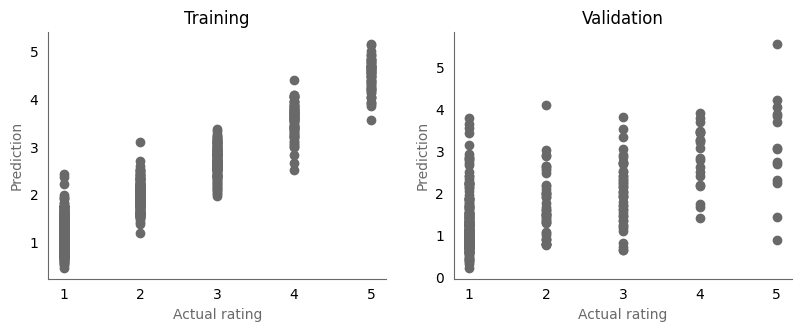

In [15]:
# Training vs Validation
training_pred_pd = training_pred.toPandas()
valid_pred_pd = valid_pred.toPandas()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6.4*1.5, 4.8/1.5))
for ax in axes:
  ax.tick_params(bottom=False, left=False)
  ax.grid(False)
  ax.spines[['top', 'right']].set_visible(False)
  ax.spines[['left', 'bottom']].set_color('dimgray')
  ax.set_xlabel('Actual rating', fontsize=10, color='dimgray')
  ax.set_ylabel('Prediction', fontsize=10, color='dimgray')

axes[0].scatter(training_pred_pd['rating'], training_pred_pd['prediction'], color='dimgray')
axes[0].set_title(f'Training')
axes[1].scatter(valid_pred_pd['rating'], valid_pred_pd['prediction'], color='dimgray')
axes[1].set_title(f'Validation');

### Ranking metrics
* Trying to predict behaviour

In [16]:
# Recommend k movies for each user
from pyspark.sql.functions import col, udf
from pyspark.sql.types import FloatType, ArrayType, StructType, IntegerType, DoubleType

k = 25
print(f"Recommended top {k} movies by user with the corresponding predicted ratings:")
userRecs = local_model.recommendForAllUsers(k)
userRecs.show(5, truncate=False)

Recommended top 25 movies by user with the corresponding predicted ratings:
+------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                                                                                                                                                                                                                                                                                                                                                   |
+------+------------------------------------------------------------

In [17]:
# Filter out movie ratings

# Define udf
def extract_udf(lst):
    return [item.movieId for item in lst]

# Register udf
extract_udf_spark = udf(extract_udf, ArrayType(IntegerType()))

# Apply udf to the "k recommendations" column
userRecs = userRecs.withColumn("k recommendations", extract_udf_spark(col("recommendations")))
userRecs = userRecs.select("userId", "k recommendations")
userRecs.show(5, truncate=False)

+------+---------------------------------------------------------------------------------------------------+
|userId|k recommendations                                                                                  |
+------+---------------------------------------------------------------------------------------------------+
|28    |[92, 12, 89, 49, 2, 82, 39, 4, 93, 24, 23, 9, 18, 91, 25, 0, 36, 88, 13, 41, 32, 40, 16, 86, 80]   |
|26    |[51, 30, 24, 32, 88, 22, 23, 7, 75, 69, 94, 68, 54, 73, 98, 4, 92, 80, 74, 79, 36, 77, 90, 18, 21] |
|27    |[28, 38, 83, 66, 19, 39, 33, 75, 79, 37, 51, 7, 69, 23, 55, 30, 48, 80, 32, 44, 35, 94, 27, 34, 11]|
|12    |[55, 27, 32, 90, 65, 64, 46, 35, 49, 17, 94, 50, 16, 10, 23, 48, 7, 68, 66, 31, 13, 33, 91, 73, 20]|
|22    |[51, 88, 30, 77, 74, 75, 7, 69, 98, 68, 54, 32, 62, 24, 29, 53, 21, 90, 80, 92, 18, 52, 94, 36, 41]|
+------+---------------------------------------------------------------------------------------------------+
only showing top 5 

In [18]:
# Create a list of movies seen by each user (i.e. in the training data)
from pyspark.sql.functions import collect_list
user_train_items = training_DF.groupby('userId').agg(collect_list('movieId').alias("train items"))
user_train_items.show(5, truncate=False)

+------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userId|train items                                                                                                                                                             |
+------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|26    |[0, 1, 2, 3, 4, 5, 6, 7, 13, 14, 16, 18, 20, 21, 22, 23, 24, 27, 31, 35, 40, 44, 45, 47, 49, 50, 52, 54, 55, 57, 61, 62, 66, 68, 71, 73, 76, 81, 85, 86, 88, 91, 95, 96]|
|29    |[3, 4, 5, 7, 9, 10, 13, 14, 15, 17, 19, 22, 25, 29, 31, 32, 33, 36, 38, 39, 42, 46, 49, 51, 59, 61, 62, 68, 69, 70, 74, 75, 79, 80, 81, 83, 85, 86, 90, 93, 94, 97, 99] |
|19    |[0, 1, 2, 4, 6, 11, 23, 26, 31, 33, 34, 37, 38, 41, 43, 45, 48, 49, 50, 53, 54, 55, 56, 58, 61, 62, 64

In [19]:
# Create a list of movies in the test set by user (i.e. the ground truth)
user_test_items = valid_DF.groupby('userId').agg(collect_list('movieId').alias("test items"))
user_test_items.show(5, truncate=False)

+------+-----------------------------------------------------------+
|userId|test items                                                 |
+------+-----------------------------------------------------------+
|26    |[36, 48, 58, 94, 97]                                       |
|29    |[11, 23, 67]                                               |
|19    |[12, 14, 32, 63, 69, 81, 86, 95]                           |
|0     |[44, 45, 55, 59, 61, 72, 77, 83]                           |
|22    |[9, 10, 11, 22, 33, 35, 61, 66, 70, 75, 78, 84, 87, 96, 99]|
+------+-----------------------------------------------------------+
only showing top 5 rows



In [20]:
# Filter out recommendations already seen (i.e. in the training data)

# Join DataFrames giving k recommendations, training items & test items by user
user_eval = userRecs.join(user_train_items, on='userId').join(user_test_items, on='userId')
user_eval.show(5)

# Create udf
def filter_train_items_udf(k_recommendations, train_items):
    return [item for item in k_recommendations if item not in train_items]

# Register udf
filter_train_items_udf_spark = udf(filter_train_items_udf, ArrayType(IntegerType()))

# Apply udf to the "k recommendations" column
user_eval = user_eval.withColumn("filtered k recommendations", filter_train_items_udf_spark(col("k recommendations"), col("train items")))
user_eval = user_eval.select("userId", "filtered k recommendations", "test items")
user_eval.show(5, truncate=False)

+------+--------------------+--------------------+--------------------+
|userId|   k recommendations|         train items|          test items|
+------+--------------------+--------------------+--------------------+
|    26|[51, 30, 24, 32, ...|[0, 1, 2, 3, 4, 5...|[36, 48, 58, 94, 97]|
|    29|[46, 90, 32, 23, ...|[3, 4, 5, 7, 9, 1...|        [11, 23, 67]|
|    19|[51, 90, 75, 54, ...|[0, 1, 2, 4, 6, 1...|[12, 14, 32, 63, ...|
|     0|[92, 93, 18, 2, 8...|[2, 3, 5, 9, 11, ...|[44, 45, 55, 59, ...|
|    22|[51, 88, 30, 77, ...|[0, 3, 5, 6, 13, ...|[9, 10, 11, 22, 3...|
+------+--------------------+--------------------+--------------------+
only showing top 5 rows

+------+--------------------------------------------------------------------------+-----------------------------------------------------------+
|userId|filtered k recommendations                                                |test items                                                 |
+------+-------------------------------

In [21]:
# Cast the "filtered_k_recommendations" column to an array of double
from pyspark.sql.types import DoubleType
from pyspark.ml.evaluation import RankingEvaluator

user_eval = user_eval.withColumn("filtered k recommendations", col("filtered k recommendations").cast(ArrayType(DoubleType())))
user_eval = user_eval.withColumn("test items", col("test items").cast(ArrayType(DoubleType())))

evaluator = RankingEvaluator()
evaluator.setPredictionCol("filtered k recommendations")
evaluator.setLabelCol("test items")

print("Precision@k:", evaluator.evaluate(user_eval, {evaluator.metricName: "precisionAtK", evaluator.k: 10}))
print("Recall@k:", evaluator.evaluate(user_eval, {evaluator.metricName: "recallAtK", evaluator.k: 10}))
print("Mean Average Precision@k:", evaluator.evaluate(user_eval, {evaluator.metricName: "meanAveragePrecisionAtK", evaluator.k: 10}))

Precision@k: 0.18000000000000002
Recall@k: 0.1714408358526006
Mean Average Precision@k: 0.08710989858906525


## User recommendation
**Key observations:**
* Recommendations are made by making predictions for all movies in the test data (followed by sorting).

  Note: There is no overlap between the ratings history for a user, as given in the training data, and the shortlist of movies in the test data.

In [22]:
# Recommendations from the test data
USER_ID = 26
print(f"Shortlist of movies in the test data:")
user_shortlist = valid_DF.filter(valid_DF['userId']==USER_ID).select(['movieId', 'userId'])
user_shortlist.show()

print(f"Top 5 recommendations:")
user_recommend = local_model.transform(user_shortlist)
user_recommend.orderBy('prediction', ascending=False).show(5)

Shortlist of movies in the test data:
+-------+------+
|movieId|userId|
+-------+------+
|     36|    26|
|     48|    26|
|     58|    26|
|     94|    26|
|     97|    26|
+-------+------+

Top 5 recommendations:
+-------+------+----------+
|movieId|userId|prediction|
+-------+------+----------+
|     94|    26| 4.0787315|
|     36|    26|  3.293958|
|     48|    26| 2.8650863|
|     97|    26| 0.7208201|
|     58|    26| 0.3875026|
+-------+------+----------+



# Train a model (in the cloud)
**Key observation:**
* The final model will be trained using all available data. This will be achieved using the Google Cloud platform.

## Data
**Key observation:**
* The data is available in csv form. Consequently, the data prep process will need to be adjusted.

In [23]:
!wc "/content/drive/MyDrive/Data science jobs/3. Interview prep/Google Cloud/Dataproc/ratings.csv"
print("\n")
!head -n 5 "/content/drive/MyDrive/Data science jobs/3. Interview prep/Google Cloud/Dataproc/ratings.csv"

 100837  100837 2483723 /content/drive/MyDrive/Data science jobs/3. Interview prep/Google Cloud/Dataproc/ratings.csv


userId,movieId,rating,timestamp
1,1,4.0,964982703
1,3,4.0,964981247
1,6,4.0,964982224
1,47,5.0,964983815


## Training py script
* Read directly into spark dataframe
* Update hyperparamters - add maxIter
* Explicitly name bestModel
* Calculate RMSE/MAE/R-squared on training & test set with bestModel


In [24]:
%%writefile "/content/drive/MyDrive/Data science jobs/3. Interview prep/Google Cloud/Dataproc/als_model.py"
import sys
from math import sqrt
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

INPUT_PATH = sys.argv[1] # parse file path from command line

if __name__ == '__main__':

    # Create SparkContext and SparkSession
    sc = SparkContext(appName="spark-submit demo")
    spark = SparkSession.builder.getOrCreate()

    # 1. Training/test split
    ratings_DF = spark.read.csv("gs://arctic-crawler-403811-storage/ratings.csv", header=True, inferSchema=True)
    (training_DF, test_DF) = ratings_DF.randomSplit([0.8, 0.2], seed=10)
    training_DF.createOrReplaceTempView('training_DF')
    test_DF.createOrReplaceTempView('test_DF')
    training_DF.write.csv("gs://arctic-crawler-403811-storage/movie_rec_171123_training_DF/", mode="overwrite", header=True)
    test_DF.write.csv("gs://arctic-crawler-403811-storage/movie_rec_171123_test_DF/", mode="overwrite", header=True)

    # 2. Baseline RMSE
    row_baseline = spark.sql("SELECT AVG(rating) FROM training_DF").first()
    baseline = row_baseline['avg(rating)']
    se_RDD = test_DF.rdd.map(lambda row: Row(se=pow(row['rating']-baseline, 2)))
    se_DF = spark.createDataFrame(se_RDD)
    se_DF.createOrReplaceTempView('se_DF')
    row_avg = spark.sql("SELECT AVG(se) FROM se_DF").first()
    baseline_rmse = sqrt(row_avg['avg(se)'])
    print(f"Baseline RMSE: {baseline_rmse}")

    # 3. Hyperparameter tuning
    als = ALS(maxIter=10, rank=10, regParam=0.05, userCol="userId", itemCol="movieId", ratingCol="rating", nonnegative=True, coldStartStrategy='drop', seed=1)
    param_grid = ParamGridBuilder().addGrid(als.rank, [5, 10, 15, 20]).addGrid(als.regParam, [0.01, 0.05, 0.1, 0.15, 0.2]).addGrid(als.maxIter, [5, 10, 15, 20]).build()
    reg_eval = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
    kfold_cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=reg_eval, numFolds=5)
    cv_model = kfold_cv.fit(training_DF)

    # 4. Save best model
    param_map = zip(cv_model.getEstimatorParamMaps(), cv_model.avgMetrics)
    param_min = min(param_map, key=lambda x: x[1])
    print(f"Optimal configuration: {param_min}")

    best_model = cv_model.bestModel
    best_model.write().overwrite().save("gs://arctic-crawler-403811-storage/movie_rec_171123")

    # 5. Evaluate best model
    print("Training set performance")
    training_pred = best_model.transform(training_DF)
    for metric in ['rmse', 'mae', 'r2']:
      reg_eval = RegressionEvaluator(metricName=metric, labelCol="rating", predictionCol="prediction")
      reg_score = reg_eval.evaluate(training_pred)
      print(f"{metric}: {reg_score}")

    print("Test set performance")
    test_pred = best_model.transform(test_DF)
    for metric in ['rmse', 'mae', 'r2']:
      reg_eval = RegressionEvaluator(metricName=metric, labelCol="rating", predictionCol="prediction")
      reg_score = reg_eval.evaluate(test_pred)
      print(f"{metric}: {reg_score}")

    # 6. Shutdown Spark context
    sc.stop()

Overwriting /content/drive/MyDrive/Data science jobs/3. Interview prep/Google Cloud/Dataproc/als_model.py


## Training via dataproc

**Why Dataproc?**

It allows easy integration with PySpark. With Dataproc, you can easily deploy Spark clusters, scale resources dynamically, and process large-scale data using PySpark, leveraging the power of Spark's distributed computing capabilities for efficient data analysis and processing in a cloud environment.

### Authentication

In [25]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

### Project configuration

In [26]:
PROJECT_ID = "arctic-crawler-403811"
REGION = "us-central1"

# !gcloud projects create $PROJECT_ID
!gcloud config set project $PROJECT_ID
!gcloud config set compute/region $REGION
!gcloud config set dataproc/region $REGION
!echo "gcloud config list"
!gcloud config list

Updated property [core/project].
Updated property [compute/region].
Updated property [dataproc/region].
gcloud config list
[component_manager]
disable_update_check = True
[compute]
region = us-central1
[core]
account = billypitchford@gmail.com
project = arctic-crawler-403811
[dataproc]
region = us-central1

Your active configuration is: [default]


### Data upload

In [27]:
# Create storage bucket
BUCKET = f"gs://{PROJECT_ID}-storage"
!gsutil mb $BUCKET
print(BUCKET)

Creating gs://arctic-crawler-403811-storage/...
gs://arctic-crawler-403811-storage


In [28]:
# Copy data to storage bucket
FILEPATH = "/content/drive/MyDrive/Data science jobs/3. Interview prep/Google Cloud/Dataproc/ratings.csv"
!gsutil -m cp "$FILEPATH" $BUCKET # Enclosed FILEPATH variable in double quotes to handle spaces in path
BUCKET_PATH = BUCKET + "/ratings.csv"
print(BUCKET_PATH)

Copying file:///content/drive/MyDrive/Data science jobs/3. Interview prep/Google Cloud/Dataproc/ratings.csv [Content-Type=text/csv]...
-
Operation completed over 1 objects/2.4 MiB.                                      
gs://arctic-crawler-403811-storage/ratings.csv


### Dataproc cluster creation
**Key observations:**

The specific configuration for the cluster is defined in the subsequent options.

* --image-version 1.4-ubuntu18

  Specifies the version of the Dataproc image to be used. In this case, it's using version 1.4 with Ubuntu 18.

* --single-node

  Configures the cluster to have a single master node.

* --master-machine-type n1-standard-2

  Specifies the machine type for the master node. In this case, it's an n1-standard-2 machine type.

* --master-boot-disk-type pd-ssd --master-boot-disk-size 100

  Specifies the type and size of the master node's boot disk. In this case, it's using an SSD disk with a size of 100 GB.

* --max-idle 3600s

  Sets the maximum idle time for the cluster to 3600 seconds (1 hour). If the cluster is idle for this duration, it will be automatically deleted to avoid unnecessary costs.

Note:
* If the cell execution is stopped, the process will still continue in the cloud.

In [29]:
CLUSTER = f"{PROJECT_ID}-cluster"
!gcloud dataproc clusters create $CLUSTER \
    --image-version 1.4-ubuntu18 \
    --single-node \
    --master-machine-type n1-standard-2 \
    --master-boot-disk-type pd-ssd \
    --master-boot-disk-size 100 \
    --max-idle 3600s

Waiting on operation [projects/arctic-crawler-403811/regions/us-central1/operations/b7362e6e-660a-3b7f-a9d9-e36841eca256].

Created [https://dataproc.googleapis.com/v1/projects/arctic-crawler-403811/regions/us-central1/clusters/arctic-crawler-403811-cluster] Cluster placed in zone [us-central1-f].


### Job submission

In [30]:
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER "/content/drive/MyDrive/Data science jobs/3. Interview prep/Google Cloud/Dataproc/als_model.py" -- $BUCKET_PATH

Job [5dc3d6c3eec146658b536bb2892949e1] submitted.
Waiting for job output...
23/11/22 12:55:35 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/11/22 12:55:35 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/11/22 12:55:35 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
23/11/22 12:55:35 INFO org.spark_project.jetty.util.log: Logging initialized @4965ms to org.spark_project.jetty.util.log.Slf4jLog
23/11/22 12:55:36 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; built: unknown; git: unknown; jvm 1.8.0_312-b07
23/11/22 12:55:36 INFO org.spark_project.jetty.server.Server: Started @5165ms
23/11/22 12:55:36 INFO org.spark_project.jetty.server.AbstractConnector: Started ServerConnector@124b465a{HTTP/1.1, (http/1.1)}{0.0.0.0:4040}
23/11/22 12:55:36 WARN org.apache.spark.scheduler.FairSchedulableBuilder: Fair Scheduler configuration file not found so jobs will be scheduled in FIFO order. To use fair scheduling, configure poo

### Downloads

In [31]:
DESTINATION_PATH = "/content/drive/MyDrive/Data science jobs/3. Interview prep/Google Cloud/Dataproc"

# Training data
SOURCE_PATH = "gs://arctic-crawler-403811-storage/movie_rec_171123_training_DF"
!gsutil -m cp -r $SOURCE_PATH "$DESTINATION_PATH"

# Test data
SOURCE_PATH = "gs://arctic-crawler-403811-storage/movie_rec_171123_test_DF"
!gsutil -m cp -r $SOURCE_PATH "$DESTINATION_PATH"

# Model
SOURCE_PATH = "gs://arctic-crawler-403811-storage/movie_rec_171123"
!gsutil -m cp -r $SOURCE_PATH "$DESTINATION_PATH"

Copying gs://arctic-crawler-403811-storage/movie_rec_171123_training_DF/_SUCCESS...
Copying gs://arctic-crawler-403811-storage/movie_rec_171123_training_DF/part-00000-d8ae49e7-cd56-436f-b953-918be18f766d-c000.csv...
Copying gs://arctic-crawler-403811-storage/movie_rec_171123_test_DF/_SUCCESS...
Copying gs://arctic-crawler-403811-storage/movie_rec_171123_test_DF/part-00000-b1c95eca-7c7a-4c42-96a2-ee0022e06a3b-c000.csv...
Copying gs://arctic-crawler-403811-storage/movie_rec_171123/itemFactors/part-00000-7d7a4fe8-97f9-48ba-b895-21d682bdd897-c000.snappy.parquet...
Copying gs://arctic-crawler-403811-storage/movie_rec_171123/itemFactors/_SUCCESS...
Copying gs://arctic-crawler-403811-storage/movie_rec_171123/itemFactors/part-00001-7d7a4fe8-97f9-48ba-b895-21d682bdd897-c000.snappy.parquet...
Copying gs://arctic-crawler-403811-storage/movie_rec_171123/itemFactors/part-00002-7d7a4fe8-97f9-48ba-b895-21d682bdd897-c000.snappy.parquet...
Copying gs://arctic-crawler-403811-storage/movie_rec_171123/ite

### Clean up
* To avoid further costs, the cluster and storage buckets are deleted

In [ ]:
# Cluster
!gcloud dataproc clusters delete $CLUSTER --region=$REGION

# Storage bucket
BUCKET = "gs://arctic-crawler-403811-storage/"
!gsutil -m rm -r $BUCKET

## Evaluation

In [4]:
TRAIN_PATH = "/content/drive/MyDrive/Data science jobs/3. Interview prep/Google Cloud/Dataproc/movie_rec_171123_training_DF/"
%cd "$TRAIN_PATH"
!cat *.csv | wc

TEST_PATH = "/content/drive/MyDrive/Data science jobs/3. Interview prep/Google Cloud/Dataproc/movie_rec_171123_test_DF/"
%cd "$TEST_PATH"
!cat *.csv | wc

/content/drive/MyDrive/Data science jobs/3. Interview prep/Google Cloud/Dataproc/movie_rec_171123_training_DF
  80881   80881 1911481
/content/drive/MyDrive/Data science jobs/3. Interview prep/Google Cloud/Dataproc/movie_rec_171123_test_DF
  19957   19957  471437


In [5]:
# Read training data into DataFrame
training_DF = spark.read.csv(TRAIN_PATH, header=True, inferSchema=True)
training_DF.createOrReplaceTempView('training_DF')
print(training_DF.count())
training_DF.show(5)
training_DF.printSchema()

80880
+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
|     1|     70|   3.0|964982400|
+------+-------+------+---------+
only showing top 5 rows

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



In [6]:
# Read test data into DataFrame
test_DF = spark.read.csv(TEST_PATH, header=True, inferSchema=True)
test_DF.createOrReplaceTempView('test_DF')
print(test_DF.count())
test_DF.show(5)
test_DF.printSchema()

19956
+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      6|   4.0|964982224|
|     1|    151|   5.0|964984041|
|     1|    480|   4.0|964982346|
|     1|    500|   3.0|964981208|
|     1|    552|   4.0|964982653|
+------+-------+------+---------+
only showing top 5 rows

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



In [7]:
# Read pickled model
from pyspark.ml.recommendation import ALSModel
MODEL_PATH = "/content/drive/MyDrive/Data science jobs/3. Interview prep/Google Cloud/Dataproc/movie_rec_171123"
gcloud_model = ALSModel.load(MODEL_PATH)

### Rating metrics

In [9]:
# Training set
from pyspark.ml.evaluation import RegressionEvaluator
training_pred = gcloud_model.transform(training_DF)
for metric in ['rmse', 'mae', 'r2']:
  reg_eval = RegressionEvaluator(metricName=metric, labelCol="rating", predictionCol="prediction")
  reg_score = reg_eval.evaluate(training_pred)
  print(f"{metric}: {reg_score}")

rmse: 0.6262255428931269
mae: 0.48351170391021214
r2: 0.6390063061188556


In [10]:
# Test set
test_pred = gcloud_model.transform(test_DF)
for metric in ['rmse', 'mae', 'r2']:
  reg_eval = RegressionEvaluator(metricName=metric, labelCol="rating", predictionCol="prediction")
  reg_score = reg_eval.evaluate(test_pred)
  print(f"{metric}: {reg_score}")

rmse: 0.8734771246970764
mae: 0.6799398160652055
r2: 0.2905126655477088


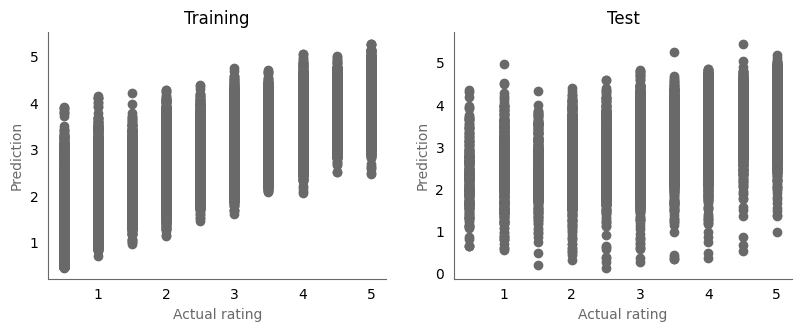

In [11]:
# Training vs Test
training_pred_pd = training_pred.toPandas()
test_pred_pd = test_pred.toPandas()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6.4*1.5, 4.8/1.5))
for ax in axes:
  ax.tick_params(bottom=False, left=False)
  ax.grid(False)
  ax.spines[['top', 'right']].set_visible(False)
  ax.spines[['left', 'bottom']].set_color('dimgray')
  ax.set_xlabel('Actual rating', fontsize=10, color='dimgray')
  ax.set_ylabel('Prediction', fontsize=10, color='dimgray')

axes[0].scatter(training_pred_pd['rating'], training_pred_pd['prediction'], color='dimgray')
axes[0].set_title(f'Training')
axes[1].scatter(test_pred_pd['rating'], test_pred_pd['prediction'], color='dimgray')
axes[1].set_title(f'Test');

### Ranking metrics

In [12]:
# Recommend k movies for each user
from pyspark.sql.functions import col, udf
from pyspark.sql.types import FloatType, ArrayType, StructType, IntegerType, DoubleType

k = 25
print(f"Recommended top {k} movies by user with the corresponding predicted ratings:")
userRecs = gcloud_model.recommendForAllUsers(k)
userRecs.show(5, truncate=False)

# Filter out movie ratings
# Define udf
def extract_udf(lst):
    return [item.movieId for item in lst]

# Register udf
extract_udf_spark = udf(extract_udf, ArrayType(IntegerType()))

# Apply udf to the "k recommendations" column
userRecs = userRecs.withColumn("k recommendations", extract_udf_spark(col("recommendations")))
userRecs = userRecs.select("userId", "k recommendations")
userRecs.show(5, truncate=False)

Recommended top 25 movies by user with the corresponding predicted ratings:
+------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                                                                                                                                                                                                                                                                                                                                               

In [13]:
# Create a list of movies seen by each user (i.e. in the training data)
from pyspark.sql.functions import collect_list
user_train_items = training_DF.groupby('userId').agg(collect_list('movieId').alias("train items"))
user_train_items.show(5, truncate=False)

# Create a list of movies in the test set by user (i.e. the ground truth)
user_test_items = test_DF.groupby('userId').agg(collect_list('movieId').alias("test items"))
user_test_items.show(5, truncate=False)

+------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userId|train items                                                                                                                                                                                                                                           |
+------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|148   |[356, 4308, 4896, 4993, 5618, 5816, 5952, 6377, 30816, 40629, 40815, 44191, 50872, 54001, 60069, 68954, 69844, 72998, 76093, 79091, 79132, 81847, 89745, 98243, 98491, 108932, 110102, 112175, 116797, 122882, 122920, 134853, 1

In [14]:
# Filter out recommendations already seen (i.e. in the training data)

# Join DataFrames giving k recommendations, training items & test items by user
user_eval = userRecs.join(user_train_items, on='userId').join(user_test_items, on='userId')
user_eval.show(5)

# Create udf
def filter_train_items_udf(k_recommendations, train_items):
    return [item for item in k_recommendations if item not in train_items]

# Register udf
filter_train_items_udf_spark = udf(filter_train_items_udf, ArrayType(IntegerType()))

# Apply udf to the "k recommendations" column
user_eval = user_eval.withColumn("filtered k recommendations", filter_train_items_udf_spark(col("k recommendations"), col("train items")))
user_eval = user_eval.select("userId", "filtered k recommendations", "test items")
user_eval.show(5, truncate=False)

+------+--------------------+--------------------+--------------------+
|userId|   k recommendations|         train items|          test items|
+------+--------------------+--------------------+--------------------+
|   148|[33649, 77846, 25...|[356, 4308, 4896,...|[1197, 4886, 7153...|
|   463|[7842, 68945, 337...|[110, 296, 527, 5...|[356, 520, 1552, ...|
|   471|[68945, 3379, 177...|[1, 296, 356, 527...| [2324, 6539, 44191]|
|   496|[68945, 3379, 897...|[720, 858, 904, 9...|[1221, 95167, 104...|
|   243|[6818, 8477, 1417...|[44, 48, 62, 112,...|[10, 36, 165, 434...|
+------+--------------------+--------------------+--------------------+
only showing top 5 rows

+------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------+
|userId|filtered k recommendations              

In [15]:
# Cast the "filtered_k_recommendations" column to an array of double
from pyspark.sql.types import DoubleType
from pyspark.ml.evaluation import RankingEvaluator

user_eval = user_eval.withColumn("filtered k recommendations", col("filtered k recommendations").cast(ArrayType(DoubleType())))
user_eval = user_eval.withColumn("test items", col("test items").cast(ArrayType(DoubleType())))

evaluator = RankingEvaluator()
evaluator.setPredictionCol("filtered k recommendations")
evaluator.setLabelCol("test items")

print("Precision@k:", evaluator.evaluate(user_eval, {evaluator.metricName: "precisionAtK", evaluator.k: 10}))
print("Recall@k:", evaluator.evaluate(user_eval, {evaluator.metricName: "recallAtK", evaluator.k: 10}))
print("Mean Average Precision@k:", evaluator.evaluate(user_eval, {evaluator.metricName: "meanAveragePrecisionAtK", evaluator.k: 10}))

Precision@k: 0.0011494252873563218
Recall@k: 0.0003750763423298888
Mean Average Precision@k: 0.00040959678890713377


## User recommendation

In [16]:
# Recommendations from the test data
USER_ID = 20
print(f"Shortlist of movies in the test data:")
user_shortlist = test_DF.filter(test_DF['userId']==USER_ID).select(['movieId', 'userId'])
user_shortlist.show()

print(f"Top 5 recommendations:")
user_recommend = gcloud_model.transform(user_shortlist)
user_recommend.orderBy('prediction', ascending=False).show(5)

Shortlist of movies in the test data:
+-------+------+
|movieId|userId|
+-------+------+
|     13|    20|
|    158|    20|
|    531|    20|
|    661|    20|
|    709|    20|
|    899|    20|
|    914|    20|
|    986|    20|
|   1015|    20|
|   1022|    20|
|   1031|    20|
|   1333|    20|
|   1367|    20|
|   1688|    20|
|   1876|    20|
|   2048|    20|
|   2059|    20|
|   2085|    20|
|   2092|    20|
|   2137|    20|
+-------+------+
only showing top 20 rows

Top 5 recommendations:
+-------+------+----------+
|movieId|userId|prediction|
+-------+------+----------+
|    914|    20|  4.808429|
|    899|    20|  4.744645|
|   5618|    20| 4.3870435|
|   2137|    20|  4.034315|
|   4154|    20|  4.009702|
+-------+------+----------+
only showing top 5 rows



# Conclusion